In [1]:
# Core Data Handling
import numpy as np
import pandas as pd
import os
import glob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2

# Deep Learning Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, backend as K

# Model Architecture Components
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, 
                                   Conv2DTranspose, concatenate, 
                                   Dropout, Activation, BatchNormalization,
                                   UpSampling2D, Flatten, Dense)

# Utilities
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Training Components
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **Exploratory data analysis**
The **HC18 Grand Challenge dataset** is a publicly available medical imaging dataset designed for benchmarking and advancing research in automated fetal head circumference (HC) measurement from ultrasound images
Total Images: 999 training images + 335 test images (B-mode ultrasound scans).

**Annotations:**
Training set: Includes manual HC annotations (ellipse or circle outlines) by sonographers.
Test set: Labels withheld for evaluation 
Metadata:
Gestational age (GA) of the fetus.
Image resolution (pixel-to-millimeter ratio for HC calculation).

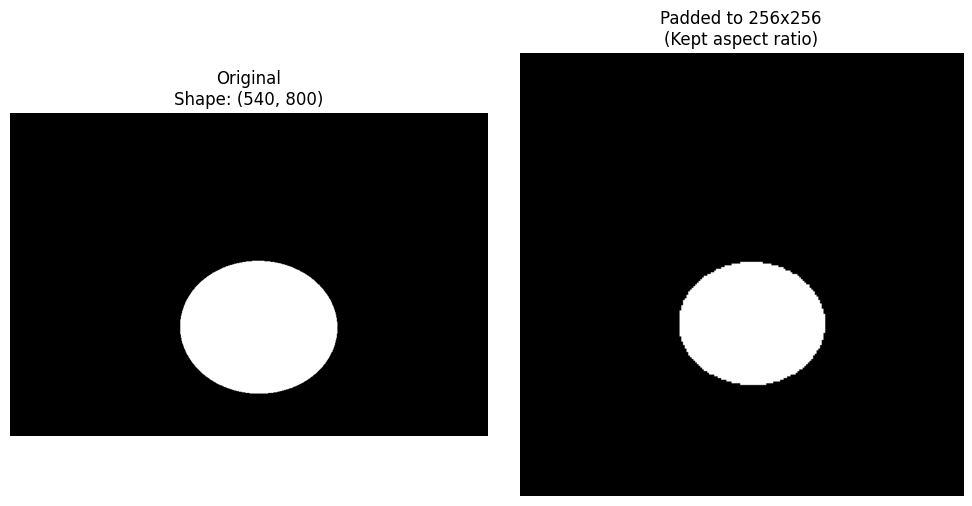

In [2]:
image = cv2.imread("/kaggle/input/hc18-split/training_mask/003_HC_Annotation.png", cv2.IMREAD_GRAYSCALE)

# --- Padding Process ---
h, w = image.shape
target_size = 256

# Resize while keeping aspect ratio
scale = min(target_size / w, target_size / h)
new_w, new_h = int(w * scale), int(h * scale)
resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)  # Preserve sharp edges

# Center on black canvas
padded = np.zeros((target_size, target_size), dtype=np.uint8)
pad_x, pad_y = (target_size - new_w) // 2, (target_size - new_h) // 2
padded[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = resized

# --- Visualization ---
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f"Original\nShape: {image.shape}")
plt.axis('off')

# Padded Image
plt.subplot(1, 2, 2)
plt.imshow(padded, cmap='gray')
plt.title(f"Padded to {target_size}x{target_size}\n(Kept aspect ratio)")
plt.axis('off')

plt.tight_layout()
plt.show()

Original Shape: (540, 800, 3)
Resized Shape: (172, 256, 3)
Padded Image Shape: (256, 256, 3)


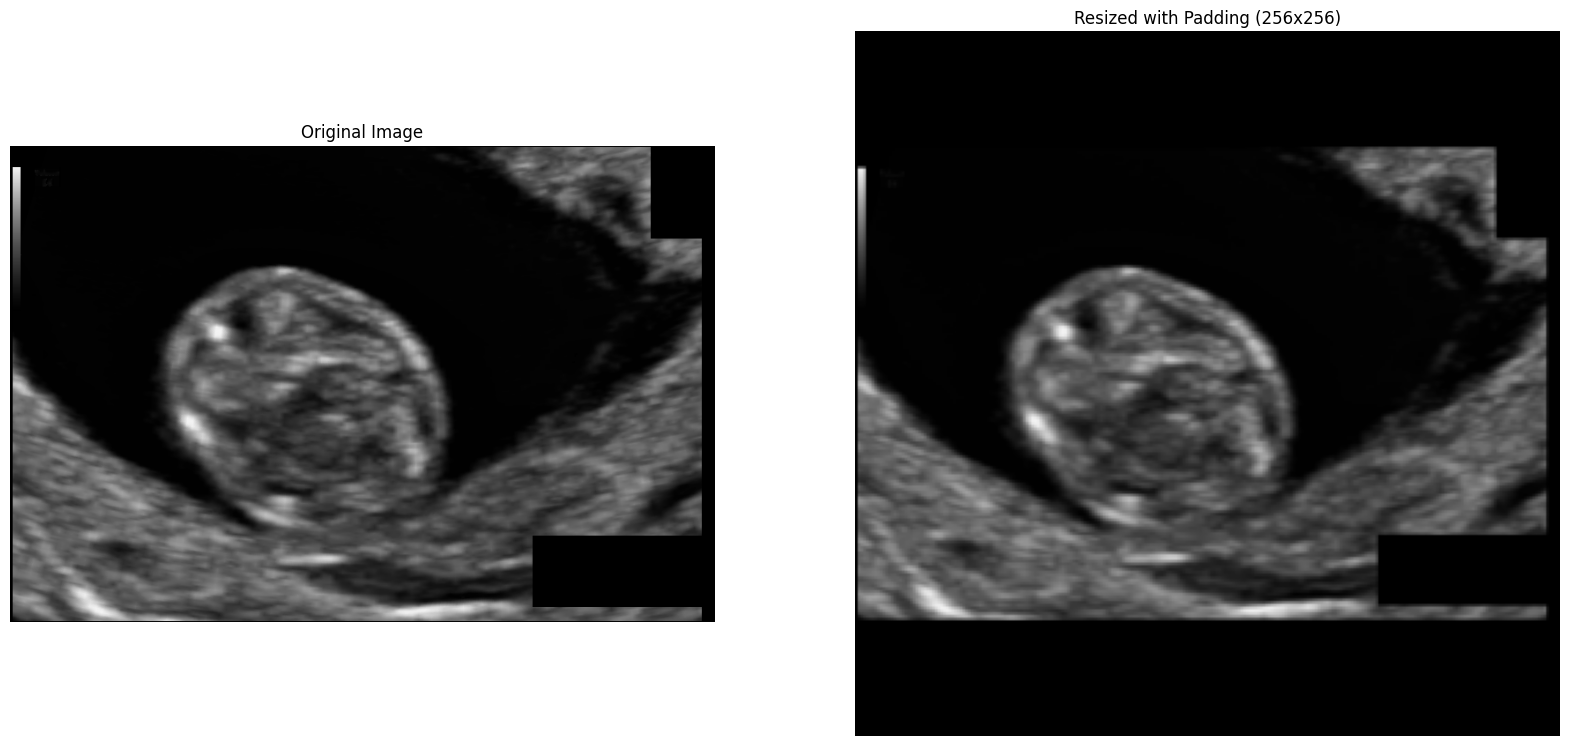

In [3]:
# Read the image
image_test = cv2.imread("/kaggle/input/hc18-split/training_set/004_HC.png")
image_rgb = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Get original shape
orig_h, orig_w = image_rgb.shape[:2]
target_size = 256  # Resize to (256,256)

# Compute aspect ratio & new size
scale = min(target_size / orig_w, target_size / orig_h)  # Maintain aspect ratio
new_w = int(orig_w * scale)
new_h = int(orig_h * scale)

# Resize while keeping aspect ratio
image_resized = cv2.resize(image_rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)

# Create black canvas (padded image)
padded_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)

# Compute padding (center the image)
pad_x = (target_size - new_w) // 2
pad_y = (target_size - new_h) // 2

# Place resized image on black background
padded_image[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = image_resized

# Show shapes
print("Original Shape:", image_rgb.shape)
print("Resized Shape:", image_resized.shape)
print("Padded Image Shape:", padded_image.shape)

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(padded_image)
ax[1].set_title("Resized with Padding (256x256)")
ax[1].axis("off")

plt.show()

In [4]:
def Encoding(input):
    skip_connections = [] 
    
    # Block 1
    conv1 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(input)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(conv1)
    conv1 = Activation('relu')(conv1)
    skip_connections.append(conv1)  # Store skip connection
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    # Block 2
    conv2 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(conv2)
    conv2 = Activation('relu')(conv2)
    skip_connections.append(conv2)  
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    # Block 3
    conv3 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(conv3)
    conv3 = Activation('relu')(conv3)
    skip_connections.append(conv3)  
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    # Block 4
    conv4 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(pool3)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(conv4)
    conv4 = Activation('relu')(conv4)
    skip_connections.append(conv4)  
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    # Bottleneck (Middle Block)
    conv5 = Conv2D(filters=1024, kernel_size=(3,3), padding='same')(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3,3), padding='same')(conv5)
    conv5 = Activation('relu')(conv5)

    return conv5, skip_connections



def decoder(encoded, skip_connections):
    conv6 = UpSampling2D(size=(2,2))(encoded)
    conv6 = concatenate([conv6, skip_connections[-1]])
    conv6 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(conv6)
    conv6 = Activation('relu')(conv6)

    conv7 = UpSampling2D(size=(2,2))(conv6)
    conv7 = concatenate([conv7, skip_connections[-2]])
    conv7 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(conv7)
    conv7 = Activation('relu')(conv7)

    conv8 = UpSampling2D(size=(2,2))(conv7)
    conv8 = concatenate([conv8, skip_connections[-3]])
    conv8 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(conv8)
    conv8 = Activation('relu')(conv8)

    conv9 = UpSampling2D(size=(2,2))(conv8)
    conv9 = concatenate([conv9, skip_connections[-4]])
    conv9 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(conv9)
    conv9 = Activation('relu')(conv9)

    conv10 = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(conv9)

    return conv10
    
def Unet(input_shape=(256,256,3)):
    inputs = Input(input_shape)
    encoded, skip_connections = Encoding(inputs)
    output = decoder(encoded, skip_connections)
    model = Model(inputs, output)
    return model
model = Unet()

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 32, 32, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Metric Evaluattion
def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def jaccard_loss(y_true, y_pred):
    return 1 - iou_score(y_true, y_pred)

In [7]:
train_origin_dir = "/kaggle/input/hc18-split/training_set"
train_mask_dir = "/kaggle/input/hc18-split/training_mask"
test_origin_dir = "/kaggle/input/hc18-split/test_set"
valid_origin_dir = "/kaggle/input/hc18-split/val_set"
valid_mask_dir = "/kaggle/input/hc18-split/val_mask"


def load_data(image_dir, mask_dir, image_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir)) 
    mask_filenames = sorted(os.listdir(mask_dir))

    # Check for dataset mismatch:
    if len(image_filenames) != len(mask_filenames):
        raise ValueError("Mismatch in the number of images and masks.")
    
    # Ensure image and mask filenames match:
    for img_file, mask_file in zip(image_filenames, mask_filenames):
        if img_file.replace('.png', '_Annotation.png') != mask_file: 
            print(f"Image file: {img_file}, Mask file: {mask_file}")  
            raise ValueError("Image and mask filenames do not match.")
    

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and check for None
        img = load_img(img_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
        
        if img is None:
            print(f"Warning: Could not load image at {img_path}. Skipping.")
            continue
        if mask is None:
            print(f"Warning: Could not load mask at {mask_path}. Skipping.")
            continue
            
        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0
        
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load full dataset into memory
X_train, Y_train = load_data(train_origin_dir, train_mask_dir)
X_valid, Y_valid = load_data(valid_origin_dir, valid_mask_dir)


# Train
model = Unet(input_shape=(256,256,3))

# Define hyperparameters
EPOCHS = 50
BATCH_SIZE = 16
learning_rate = 1e-4
smooth = 100
decay_rate = learning_rate / EPOCHS

# Define optimizer
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_loss, metrics=["binary_accuracy", iou_score, dice_coef])



# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True,  
    verbose=1
)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'unet_model.keras',  
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with early stopping and checkpointing
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint] 
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.3277 - dice_coef: 0.4453 - iou_score: 0.2889 - loss: 0.5547   
Epoch 1: val_loss improved from inf to 1.00000, saving model to unet_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - binary_accuracy: 0.3296 - dice_coef: 0.4448 - iou_score: 0.2886 - loss: 0.5552 - val_binary_accuracy: 0.6761 - val_dice_coef: 3.1569e-11 - val_iou_score: 3.1569e-11 - val_loss: 1.0000
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - binary_accuracy: 0.6983 - dice_coef: 3.1900e-11 - iou_score: 3.1900e-11 - loss: 1.0000
Epoch 2: val_loss did not improve from 1.00000
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 890ms/step - binary_accuracy: 0.6983 - dice_coef: 3.1907e-11 - iou_score: 3.1907e-11 - loss: 1.0000 - val_binary_accuracy: 0.6761 - val_dice_coef: 3.1664e-11 - val_iou_score: 3.1664e-11 - val_loss: 1.0000
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - binary_accuracy: 0.6997 - dice_coef: 3.1946e-11 - iou_score: 3.1946e-11 - loss: 1.

Bruhh, nu cep

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['binary_accuracy']
val_acc = hist.history['val_binary_accuracy']
train_dice = hist.history['dice_coef']
val_dice = hist.history['val_dice_coef']
train_iou = hist.history['iou_score']
val_iou = hist.history['val_iou_score']

epochs_range = range(len(train_loss))  

# Plotting the metrics
plt.figure(figsize=(12, 4))

# Loss Curve
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy Curve
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Dice & IoU Scores
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_dice, label='Train Dice')
plt.plot(epochs_range, val_dice, label='Val Dice')
plt.plot(epochs_range, train_iou, '--', label='Train IoU')
plt.plot(epochs_range, val_iou, '--', label='Val IoU')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Dice & IoU Scores')

plt.tight_layout()
plt.show()


In [ ]:
# Load test data (without masks)
X_test, _ = load_data(test_origin_dir)

# Make Predictions
y_pred = model.predict(X_test)

# Convert predictions to binary masks (Thresholding)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Plot first 5 images
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    # Original Image
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Predicted Mask
    axes[i, 1].imshow(y_pred_thresholded[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Predicted Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
